# Step-by-step example of JDFLOW with experimental study.
## Kirill Zakharov
2024

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline

import torch
from torch import optim
from torch.autograd import Variable, grad
from torch.autograd.functional import jacobian
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.special import rel_entr, kl_div, factorial
from scipy.spatial.distance import jensenshannon
from scipy.stats import kstest, ks_2samp, wasserstein_distance
from scipy.optimize import minimize
import scipy.stats as sts
from tqdm import tqdm
import itertools


from JDFLOW.intensity_optimization import *
from JDFLOW.signature_computation import *
from JDFLOW.stochastic_processes import *
from JDFLOW.nsde_functions import *
from JDFLOW.nsde_solvers import *
from JDFLOW.jdflow import *
from JDFLOW.evaluate.metrics import *
from JDFLOW.evaluate.graphics import *
from JDFLOW.FourierFlows import FourierFlow
from JDFLOW.FSDE import train_fsde

from Model import inverse_preprocessing,choose_data

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [2]:
import matplotlib as mpl
#set params for the article
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 13
mpl.rcParams['axes.labelsize'] = 14

#set params for the notebook
# mpl.rcParams['xtick.labelsize'] = 12
# mpl.rcParams['ytick.labelsize'] = 12
# mpl.rcParams['legend.fontsize'] = 10
# mpl.rcParams['axes.labelsize'] = 14

## Data Preparation

In [3]:
# data, dt, n = choose_data('Merton', n=1000, M=5, s0=2, xiP=10, muj=0.1, sigmaj=0.2, r=0.04, sigmad=1, T=1)
data, dt, n = choose_data('DCL', n=300, M=10, theta=1, delta=2, T=1)
# data, dt, n = choose_data('GBM', n=300, M=10, s0=1, mu=0.2, sigma=0.9, T=1)
# data, dt, n = choose_data('Stock', filename='Data/gen.us.txt')

In [4]:
# np.save('Data/Merton_jump_diffusion.npy', data)

In [5]:
# data = np.load('Data/Merton_jump_diffusion.npy')
# n = len(data[0]) - 1
# dt = 1/n

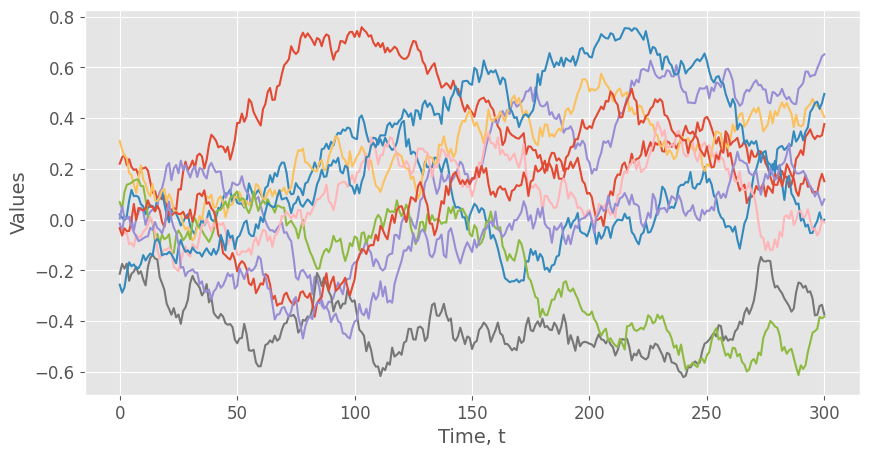

In [6]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(data.T)

plt.xlabel('Time, t')
plt.ylabel('Values')
plt.show()

Save initial data

In [7]:
data_save = copy.deepcopy(torch.FloatTensor(data))

Preprocess the data

In [8]:
scaler = MinMaxScaler((0, 1))
data = scaler.fit_transform(data.T).T

In [9]:
data_tensor = torch.FloatTensor(data)
data0 = data_tensor[0]

## Identify jump intensity

Choose the $\lambda_j$ to identify the initial jump intensity in the whole data set.

In [10]:
lambda_j = 0.8
idx_jumps = list(map(lambda x: find_jumps(x, lambda_j), data_save))

Black points show the jump positions in the inital data.

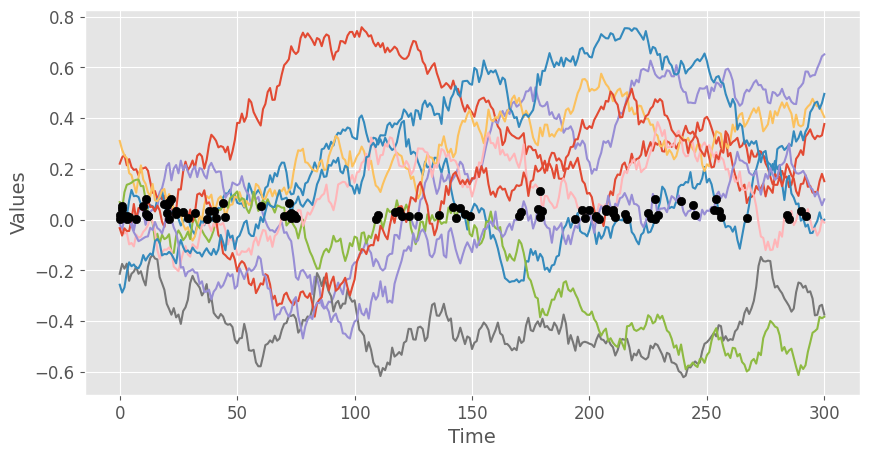

In [11]:
plot_jumps(data_save, idx_jumps)

Initial intensity

In [12]:
init_intensity = estimate_init_intensity_array(data_save, idx_jumps)/dt
init_intensity

array([ 4.9833887 , 18.93687708,  7.97342193,  0.        ,  2.99003322,
       10.96345515, 16.94352159,  4.9833887 ,  1.99335548, 18.93687708])

Initital parameters

In [13]:
jump_part, diff_part = separate_dynamics(data_save, idx_jumps)
init_params = estimate_init_params(data_save, jump_part, diff_part, dt)

Maximize likelihood

In [14]:
opt_params = optimize_params(data_save, init_params, init_intensity, dt)

In [15]:
xiP0 = opt_params[-1]
xiP0

8.870431893687707

## Signature Examples

In [16]:
signature_traj = compute_path_signature_torch(data_save, level_threshold=3)
signature = signature_set(signature_traj)[1:]

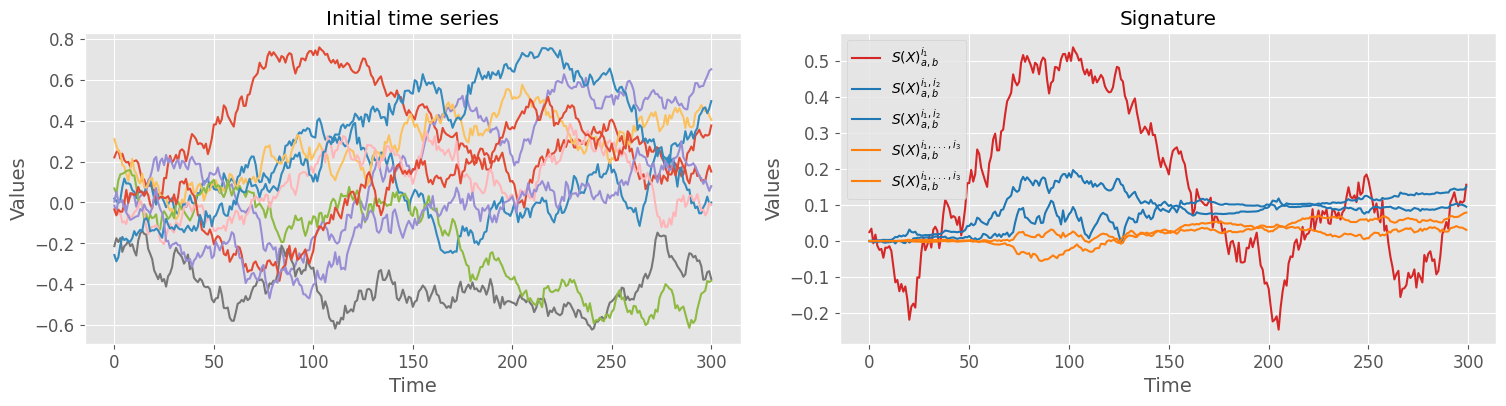

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4), dpi=100)

axs[0].plot(data_save.T)
axs[0].set_title('Initial time series')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Values')

axs[1].plot(signature_traj[1][0], color='tab:red', label='$S(X)_{a,b}^{i_1}$')
axs[1].plot(signature_traj[2][0], color='tab:blue', label='$S(X)_{a,b}^{i_1,i_2}$')
axs[1].plot(signature_traj[2][4], color='tab:blue', label='$S(X)_{a,b}^{i_1,i_2}$')
axs[1].plot(signature_traj[3][2], color='tab:orange', label='$S(X)_{a,b}^{i_1,...,i_3}$')
axs[1].plot(signature_traj[3][4], color='tab:orange', label='$S(X)_{a,b}^{i_1,...,i_3}$')
# plt.plot(signature_traj[9][0], color='tab:blue', label='$S(X)_{a,b}^{i_1,\dots,i_9}$')
axs[1].legend(fontsize=10, loc=2)
axs[1].set_title('Signature')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Values')

plt.tight_layout(pad=0.5)
plt.subplots_adjust(wspace=0.15)
# plt.savefig('Signature_ex4.pdf', dpi=300)
plt.show()

## Train model

In [19]:
h_dim = len(data_tensor[0])
M = data_tensor.size(0)
time_steps = 100
dt = torch.FloatTensor([1/time_steps])

In [20]:
n_flows = 10

nsde_flow = JDFlow(n_flows, h_dim, M, time_steps, dt, xiP0)

losses = nsde_flow.fit(data_tensor, epochs=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: -1496.9734: 100%|██████████| 1000/1000 [01:51<00:00,  8.94it/s]


In [21]:
nsde_flow.eval()

JDFlow(
  (bijections): ModuleList(
    (0): DiffMap(
      (fc_mu): Sequential(
        (0): Linear(in_features=150, out_features=128, bias=True)
        (1): Sigmoid()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): Sigmoid()
        (4): Linear(in_features=128, out_features=151, bias=True)
      )
      (fc_sig): Sequential(
        (0): LSTM(150, 150, batch_first=True)
        (1): extract_tensor()
        (2): Sigmoid()
        (3): Linear(in_features=150, out_features=128, bias=True)
        (4): Sigmoid()
        (5): Linear(in_features=128, out_features=128, bias=True)
        (6): Sigmoid()
        (7): Linear(in_features=128, out_features=151, bias=True)
      )
      (nu): Sequential(
        (0): Linear(in_features=10, out_features=128, bias=True)
        (1): Sigmoid()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): Sigmoid()
        (4): Linear(in_features=128, out_features=10, bias=True)
      )
      (p): Seq

Sample any number of synthetic time series

In [22]:
samples = nsde_flow.sample(n_samples=3*M)

In [23]:
synth_data = inverse_preprocessing(samples, M, scaler)
real_data = scaler.inverse_transform(data.T).T

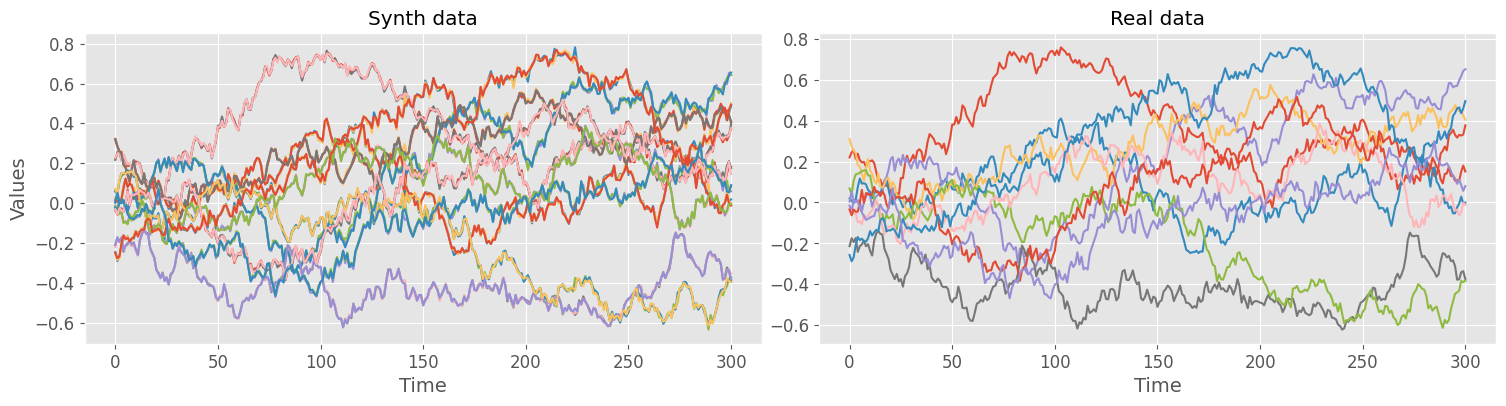

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4), dpi=100)

axs[0].plot(synth_data.T)
axs[0].set_title('Synth data')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Values')

axs[1].plot(real_data.T)
axs[1].set_title('Real data')
axs[1].set_xlabel('Time')

plt.subplots_adjust(wspace=0.1)
plt.tight_layout(pad=0.5)
# plt.savefig('Merton_many_synth2.pdf', dpi=300)
plt.show()

### Fourier Flows

In [25]:
data_tensor_ff = data_tensor[:, :(len(data_tensor[0]) // 4 * 4 + 1 if len(data_tensor[0]) % 4 > 0 else len(data_tensor[0]) - 3)]

fourier_flow = FourierFlow(2**8, len(data_tensor_ff[0]), 10, FFT=True, flip=True, normalize=False)
rnvp_flow = FourierFlow(2**8, len(data_tensor_ff[0]), 10, FFT=False, flip=True, normalize=False)

fourier_flow.fit(data_tensor_ff, epochs=1000)
rnvp_flow.fit(data_tensor_ff, epochs=1000)

Loss: -896.9069213867188: 100%|██████████| 1000/1000 [00:21<00:00, 46.84it/s]  


In [26]:
samples_ff = fourier_flow.sample(M)
samples_rnvp = rnvp_flow.sample(M)

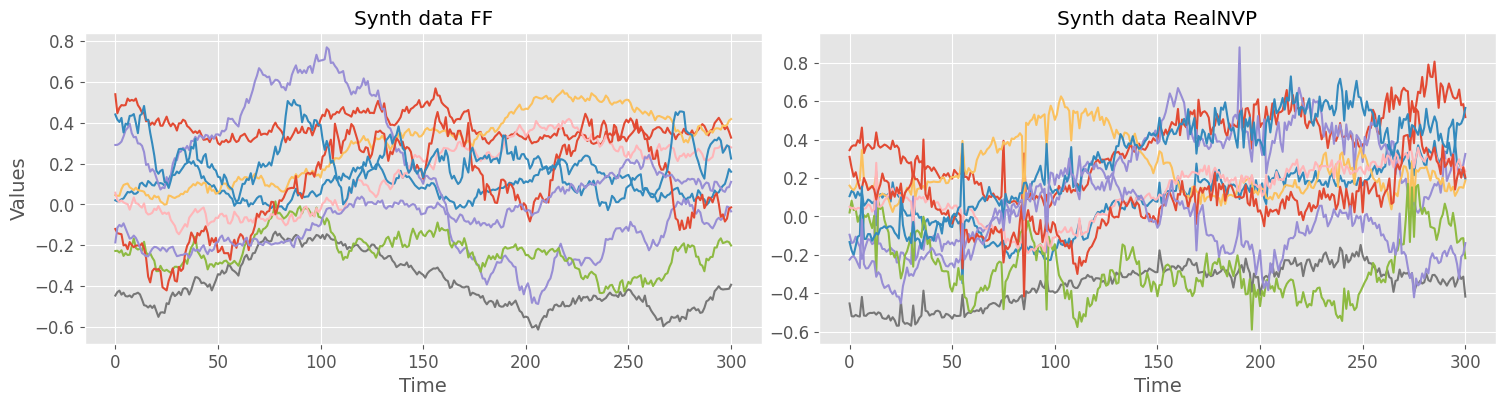

In [27]:
synth_ff = inverse_preprocessing(samples_ff, M, scaler)
synth_rnvp = inverse_preprocessing(samples_rnvp, M, scaler)

fig, axs = plt.subplots(1, 2, figsize=(15, 4), dpi=100)

# axs[0].plot(real_data.T, '--', color='black', alpha=0.7)
axs[0].plot(synth_ff.T)
axs[0].set_title('Synth data FF')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Values')

axs[1].plot(synth_rnvp.T)
axs[1].set_title('Synth data RealNVP')
axs[1].set_xlabel('Time')

plt.subplots_adjust(wspace=0.1)
plt.tight_layout(pad=0.5)
# plt.savefig('Merton_synth_FF.pdf', dpi=300)
plt.show()

### Fractional SDE-Net

Iter: 100, Log Likelihood: 1.2228, Regularization: 132.1470
Iter: 200, Log Likelihood: 1.3992, Regularization: 132.1267
Iter: 300, Log Likelihood: 1.0303, Regularization: 132.0933
Iter: 400, Log Likelihood: 0.6719, Regularization: 132.4932
Iter: 500, Log Likelihood: 0.6420, Regularization: 132.7235
Iter: 100, Log Likelihood: 1.0441, Regularization: 136.8387
Iter: 200, Log Likelihood: 1.0099, Regularization: 136.4281
Iter: 300, Log Likelihood: 1.1515, Regularization: 135.8799
Iter: 400, Log Likelihood: 1.1900, Regularization: 135.8121
Iter: 500, Log Likelihood: 1.0397, Regularization: 136.3174
Iter: 100, Log Likelihood: 1.3391, Regularization: 130.5933
Iter: 200, Log Likelihood: 1.5489, Regularization: 129.8998
Iter: 300, Log Likelihood: 1.5402, Regularization: 129.4657
Iter: 400, Log Likelihood: 1.4193, Regularization: 129.0218
Iter: 500, Log Likelihood: 1.6656, Regularization: 128.6694
Iter: 100, Log Likelihood: 0.7472, Regularization: 137.2471
Iter: 200, Log Likelihood: 0.8862, Regul

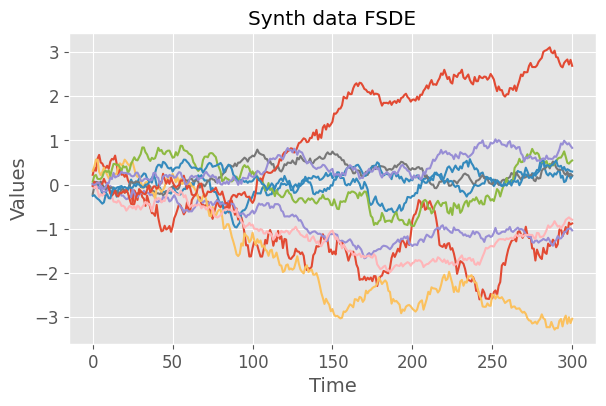

In [28]:
samples_fsde = []
for i in data_tensor:
    samples_fsde.append(train_fsde(i.view(-1, 1), method='RNN', epochs=500))
    
samples_fsde = np.array(samples_fsde)[:, 0]

synth_fsde = inverse_preprocessing(samples_fsde, M, scaler)

plt.subplots(figsize=(6, 4), dpi=100)

plt.plot(synth_fsde.T)
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Synth data FSDE')

plt.tight_layout(pad=0.5)
# plt.savefig('Merton_synth_FSDE.pdf', dpi=300)
plt.show()

### TimeGAN

In [29]:
# from JDFLOW.timeGAN import timeGAN_train

# samples_timeGAN, pca_timeGAN = timeGAN_train(data, M, 2000)
# samples_timeGAN = samples_timeGAN.T

In [30]:
# synth_timeGAN = inverse_preprocessing(samples_timeGAN, M, scaler)

In [31]:
# plt.plot(data.T, color='black', alpha=0.7)
# plt.plot(synth_timeGAN.T, alpha=0.7)
# plt.show()

### PAR from SDV

In [32]:
from sdv.sequential import PARSynthesizer
from sdv.metadata import SingleTableMetadata

df_ctgan = pd.DataFrame(data.T, columns=[f'{i}' for i in range(M)])
df_ctgan['date'] = pd.to_datetime(pd.date_range(start='2018-01-01', periods=len(data[0])), format='%Y-%m-%d')
df_ctgan['id'] = ['AAA']*len(data[0])

metadata = SingleTableMetadata()

for i in range(M):
    metadata.add_column(
        column_name=f'{i}',
        sdtype='numerical')
    
metadata.add_column(
    column_name='date',
    sdtype='datetime',
    datetime_format='%Y-%m-%d')

metadata.add_column(
    column_name='id',
    sdtype='id')

metadata.set_sequence_index(column_name='date')
metadata.set_sequence_key(column_name='id')

In [33]:
par = PARSynthesizer(metadata=metadata, epochs=500, verbose=True, enforce_min_max_values=True)
par.fit(df_ctgan)

samples_PAR = par.sample(num_sequences=1)
samples_PAR = samples_PAR.iloc[:, :M].values.T
synth_PAR = inverse_preprocessing(samples_PAR, M, scaler)

Epoch 500 | Loss -208.3435821533203: 100%|██████████| 500/500 [00:19<00:00, 26.30it/s] 
100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


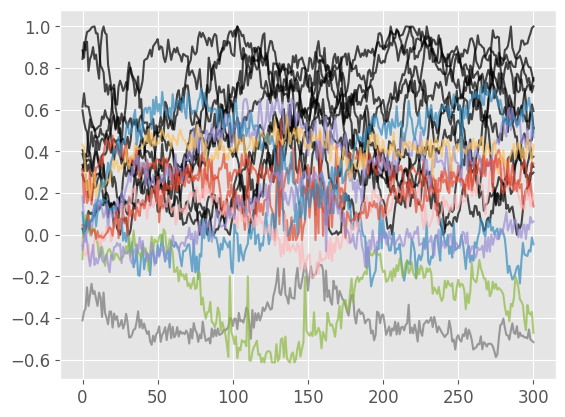

In [34]:
plt.plot(data.T, color='black', alpha=0.7)
plt.plot(synth_PAR.T, alpha=0.7)
plt.show()

## Evaluate

In [35]:
# mpl.rcParams['xtick.labelsize'] = 24
# mpl.rcParams['ytick.labelsize'] = 24
# mpl.rcParams['legend.fontsize'] = 23
# mpl.rcParams['axes.labelsize'] = 27

### Signtature distribution

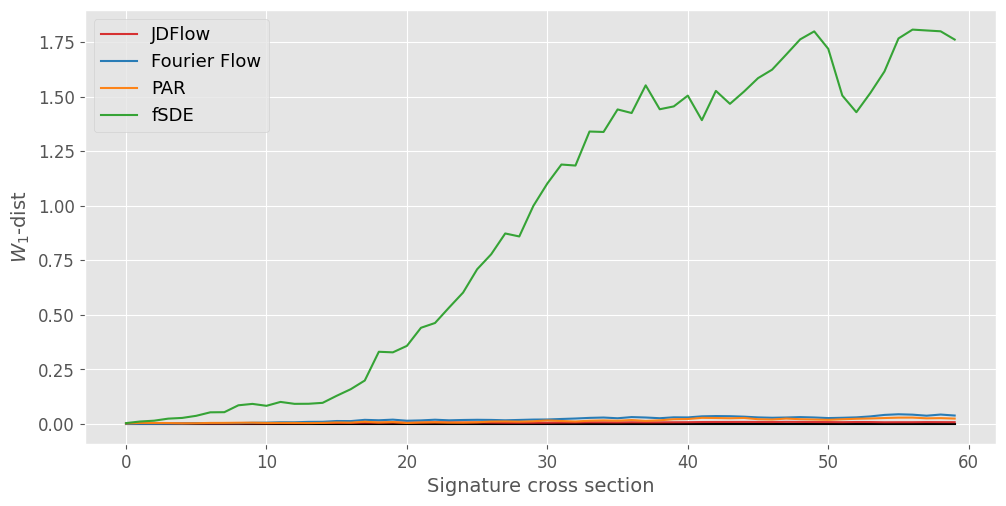

In [36]:
plot_signature_w1_dist(data_tensor, samples, samples_ff, samples_PAR, samples_fsde, save=False, name='Sig_cross_Merton')

### Local extrema QQ-plot

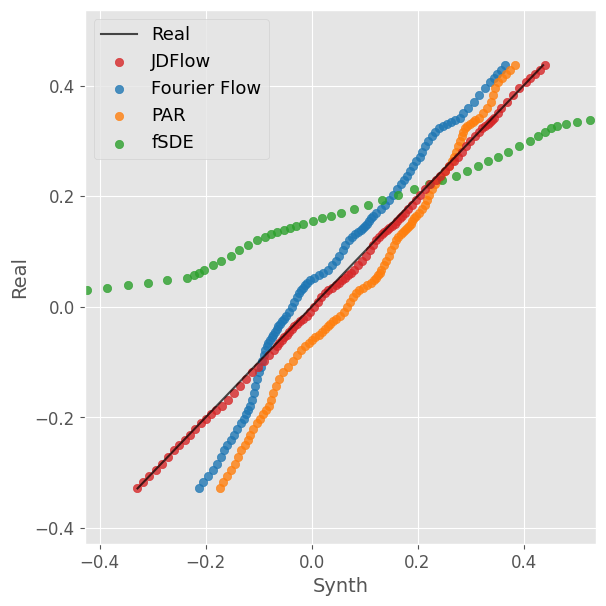

In [37]:
plot_qq_extrema_all(real_data, synth_data, synth_ff, synth_PAR, synth_fsde, save=False, name='QQExtrema')

### Autocorrelation

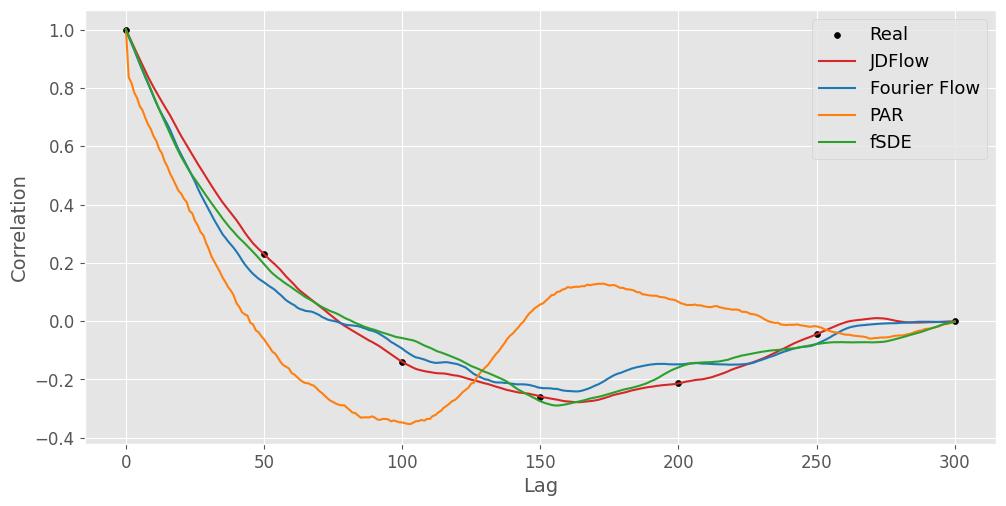

In [38]:
plot_autocorr_all(real_data, synth_data, synth_ff, synth_PAR, synth_fsde, save=False, name='Autocorrelation')

### Numerical evaluation

In [39]:
pd.DataFrame(np.array([[w_dist_calc(real_data, real_data), w_dist_calc(real_data, synth_data),
                        w_dist_calc(real_data, synth_ff), w_dist_calc(real_data, synth_PAR), w_dist_calc(real_data, synth_fsde)],
                       
                       [js_calc(np.abs(real_data), np.abs(real_data)), js_calc(np.abs(real_data), np.abs(synth_data)),
                        js_calc(np.abs(real_data), np.abs(synth_ff)), js_calc(np.abs(real_data), np.abs(synth_PAR)), js_calc(np.abs(real_data), np.abs(synth_fsde))]
                       
                       ]).T, index=['Real', 'JDFLOW', 'FF', 'PAR', 'fSDE'], columns=['W_1', 'JS'])

,W_1,JS
Real,0.000000,0.000000
JDFLOW,0.002595,0.018496
FF,0.084741,0.305135
PAR,0.101625,0.312376
fSDE,0.859108,0.299486


### TSNE

In [40]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import FastICA

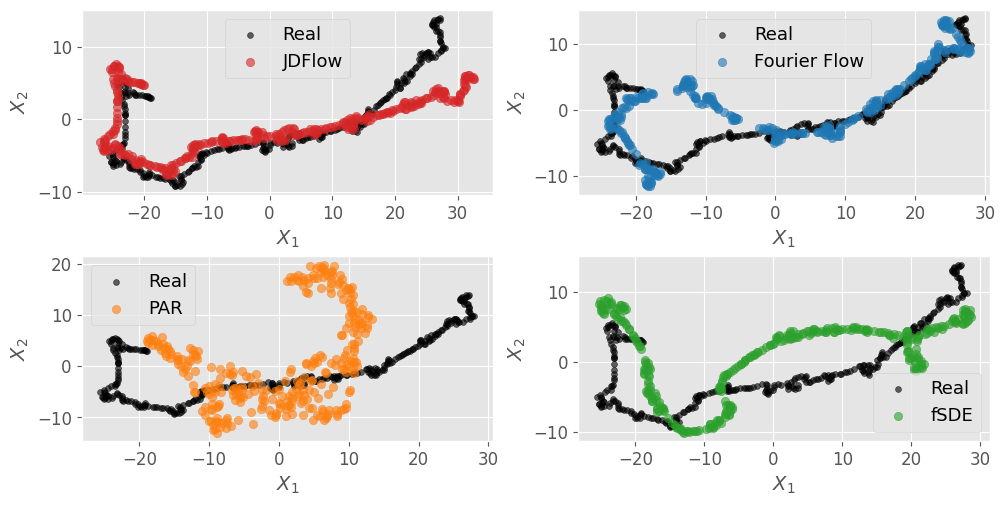

In [41]:
plot_tsne(real_data, synth_data, synth_ff, synth_PAR, synth_fsde, save=False, name='TSNE_Stock')

## Forecast metrics

In [42]:
forecast_metrics(real_data, synth_data, synth_PAR, synth_fsde, synth_ff, n=31)

12:03:24 - cmdstanpy - INFO - Chain [1] start processing
12:03:24 - cmdstanpy - INFO - Chain [1] done processing
12:03:24 - cmdstanpy - INFO - Chain [1] start processing
12:03:24 - cmdstanpy - INFO - Chain [1] done processing
12:03:24 - cmdstanpy - INFO - Chain [1] start processing
12:03:24 - cmdstanpy - INFO - Chain [1] done processing
12:03:24 - cmdstanpy - INFO - Chain [1] start processing
12:03:24 - cmdstanpy - INFO - Chain [1] done processing
12:03:24 - cmdstanpy - INFO - Chain [1] start processing
12:03:25 - cmdstanpy - INFO - Chain [1] done processing
12:03:25 - cmdstanpy - INFO - Chain [1] start processing
12:03:25 - cmdstanpy - INFO - Chain [1] done processing
12:03:25 - cmdstanpy - INFO - Chain [1] start processing
12:03:25 - cmdstanpy - INFO - Chain [1] done processing
12:03:25 - cmdstanpy - INFO - Chain [1] start processing
12:03:25 - cmdstanpy - INFO - Chain [1] done processing
12:03:25 - cmdstanpy - INFO - Chain [1] start processing
12:03:25 - cmdstanpy - INFO - Chain [1]

,Mean,Min,Max
Real,0.019505,0.010236,0.043397
JDFlow,0.019401,0.010499,0.042743
Fourier Flow,0.103817,0.016041,0.665335
PAR,0.096346,0.030472,0.172524
fSDE,1.882431,0.115480,6.578301


## Local extrema examples

In [43]:
extr_min = argrelextrema(real_data[0], np.less_equal, order=10)[0]
local_extr_min_real = real_data[0][extr_min]

extr_min_par = argrelextrema(synth_PAR[0], np.less_equal, order=10)[0]
local_extr_min_par = synth_PAR[0][extr_min_par]

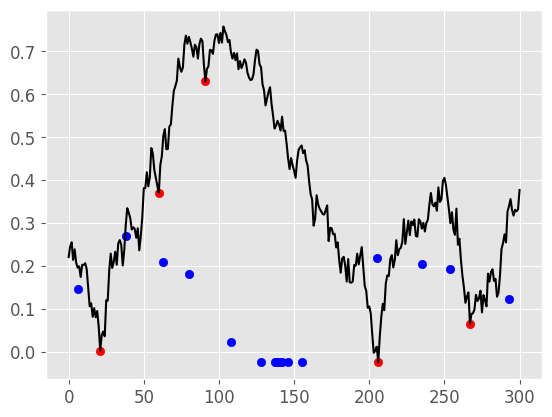

In [44]:
plt.plot(real_data[0], color='black')
plt.scatter(extr_min, local_extr_min_real, color='red')
plt.scatter(extr_min_par, local_extr_min_par, color='blue')
plt.show()